In [2]:
import numpy as np
import ROOT
import matplotlib.pyplot as plt
from matplotlib import cycler, patches
import xml.dom.minidom as minidom

import sys

sys.path.insert(1, '../../../')
from pmt_he_study.format_plot import *
from functions.other_functions import *
from src.PMT_Classes import *
from array import array
from scipy.optimize import curve_fit

Amplitude scale = 1.9571128798282273
Unit Charge = 0.12286878056263545
TFile**		/Users/williamquinn/Desktop/SNEMO/pmt_short_templates.root	
 TFile*		/Users/williamquinn/Desktop/SNEMO/pmt_short_templates.root	
  KEY: TH1D	Template_Ch0;1	Template_Ch0
  KEY: TH1D	Template_Ch1;1	Template_Ch1


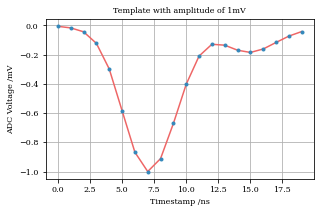

In [5]:
template_file = ROOT.TFile("/Users/williamquinn/Desktop/SNEMO/pmt_short_templates.root")
template_file.ls()

h_template = template_file.Get("Template_Ch0")
x = []
y = []

for i in range(1, h_template.GetNbinsX()+1):
    x.append(i-1)
    y.append(h_template.GetBinContent(i))
    #print(i, h_template.GetBinContent(i))
y = np.array(y)
x = np.array(x)

plt.figure(figsize=figsize, facecolor='white')
plt.plot(x, y/(-1*np.amin(y)))
plt.plot(x, y/(-1*np.amin(y)), ".")
plt.title("Template with amplitude of 1mV")

plt.xlabel("Timestamp /ns")
plt.ylabel("ADC Voltage /mV")
#y = y/(-1*np.amin(y))

normalised_y = y/np.dot(y,y)
unit_y = y/(-1*np.amin(y))

amp_scale = np.dot(normalised_y, unit_y)/np.sqrt(np.dot(normalised_y,normalised_y))

print("Amplitude scale =", amp_scale)
print("Unit Charge =", -1*np.sum(unit_y)/50)
plt.tight_layout()
# plt.savefig("/Users/williamquinn/Desktop/PMT_Project/pmt_short_template_ch0.pdf")

5.420681495410387


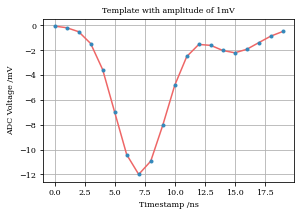

In [66]:
plt.figure(figsize=figsize, facecolor='white')
plt.plot(x, y/(-1*np.amin(y)) * 12)
plt.plot(x, y/(-1*np.amin(y)) * 12, ".")
plt.title("Template with amplitude of 1mV")

plt.xlabel("Timestamp /ns")
plt.ylabel("ADC Voltage /mV")
print(-1 * np.sum(y/(-1*np.amin(y)) * 12)/50 /1.6e-7 / 1700000)

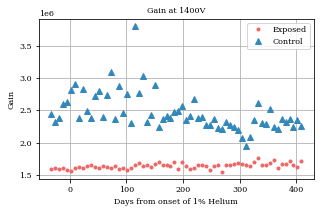

In [4]:
file = file = open("/Users/williamquinn/Desktop/test.csv", "r")
fl = file.readlines()
w = []
gain_ch0 = []
gain_ch1 = []
av_charge_ch0 = []
av_charge_ch1 = []
for index, line in enumerate(fl):
    if index == 0:
        continue
    line_list = line.split(",")
    w.append(int(line_list[0]))
    gain_ch0.append(float(line_list[5])/float(line_list[1]) * float(line_list[3]))
    gain_ch1.append(float(line_list[6])/float(line_list[2]) * float(line_list[4]))
    av_charge_ch0.append(float(line_list[7]))
    av_charge_ch1.append(float(line_list[8]))
    
w = np.array(w)
gain_ch0 = np.array(gain_ch0)
gain_ch1 = np.array(gain_ch1)
av_charge_ch0 = np.array(av_charge_ch0)
av_charge_ch1 = np.array(av_charge_ch1)
gains = [gain_ch0, gain_ch1]

plt.figure(figsize=figsize, facecolor='white')

plt.plot(w*7 + 3, gain_ch0, ".", label='Exposed')
plt.plot(w*7 + 3, gain_ch1, "^", label='Control')
plt.legend(loc='best')

plt.ylabel("Gain")
plt.xlabel("Days from onset of 1% Helium")
plt.title("Gain at 1400V")
plt.tight_layout()
# plt.savefig("/Users/williamquinn/Desktop/PMT_Project/gain_1400V.pdf")

In [6]:
topology = [2, 1]
pmt_array = PMT_Array(topology, "summary")
pmt_array.set_pmt_id("GAO612", 1)
pmt_array.set_pmt_id("GAO607", 0)
    
filenames_txt = "/Users/williamquinn/Desktop/PMT_Project/data/set_5/filenames.txt"
try:
    print(">>> Reading data from file: {}".format(filenames_txt))
    date_file = open(filenames_txt, 'r')
except FileNotFoundError as fnf_error:
    print(fnf_error)
    raise Exception("Error opening data file {}".format(filenames_txt))

filenames = np.loadtxt(filenames_txt, delimiter=',', dtype={
        'names': ['filename'],
        'formats': ['S100']}, unpack=True)

dates = [[], []]
ap_charges = [[], []]
ap_pes =[[], []]

for i_file in range(filenames.size):
    filename = filenames[i_file][0].decode("utf-8")
    date = filename.split("_")[0]
    voltage = int(filename.split("_")[1].split("A")[1])
    week = process_date([int(date)])[0] // 7
    print("> File:", filename, "week:", week)
    
    file = ROOT.TFile("/Users/williamquinn/Desktop/PMT_Project/data/set_5/" + filename, "READ")
    file.cd()
    tree = file.T
    
    temp_charge = [[], []]
    temp_pe = [[], []]
    
    for event in tree:
        om = event.OM_ID
        '''if om == 1:
            continue'''
        amps = list(event.apulse_amplitudes)
        shapes = list(event.apulse_shapes)
        ts = list(event.apulse_times)
        
        try:
            gain = gains[om][week + 5]
        except:
            print(week, date)
        
        for i_ap, ap in enumerate(amps):
            shp = shapes[i_ap]
            if shp < 0.95:
                continue
            charge = -1*np.sum(unit_y)*ap/amp_scale /50
            pe = charge*1e-12 /gain /1.602e-19 
            temp_charge[om].append(charge)
            temp_pe[om].append(pe)
            
    for om in range(2):       
        dates[om].append(process_date([int(date)])[0])      
        ap_charges[om].append(np.average(temp_charge[om]))
        ap_pes[om].append(np.average(temp_pe[om]))


#plot_aan(dates, nums, nums_err, "")
#plot_aan(dates, he_nums, he_nums_err, "he")
print(">>> Finished")

>>> Reading data from file: /Users/williamquinn/Desktop/PMT_Project/data/set_5/filenames.txt
> File: 191008_A1400_B1400_t1519.root week: -5
-5 191008


NameError: name 'gain' is not defined

In [95]:
y = [[], []]
x = [[], []]
for i in range(len(ap_charges)):
    for j in range(len(ap_charges[i])):
        if ap_charges[i][j] > 4:
            pass
        elif str(ap_charges[i][j]) == 'nan':
            pass
        else:
            y[i].append(ap_charges[i][j])
            x[i].append(dates[i][j])

[1.6762703318173429, 1.7180327197989729, 1.6811800597874003, 1.6774290509771028, 1.6633575836633763, 1.676248572838631, 1.6551955565578285, 1.6748750249276592, 1.6417466209103615, 1.6241069222525226, 1.6470235192861453, 1.7724356908021233, 1.6995580654938125, 1.7573532912733003, 1.6704254471942899, 1.6770477528814807, 1.6784152600895899, 1.6771866969358638, 1.6400543781457857, 1.6730602054941615, 1.6569781665720973, 1.6812259420251823, 1.690652764982282, 1.6697172494314343, 1.6691108326754955, 1.6599848390655116, 1.7554573475984487, 1.6681018835502932, 1.7078811336266104, 1.7142343780392633, 1.7190048190428517, 1.6851416735868137, 1.7752374242996354, 1.7638632360254074, 1.8857322358285502, 1.7733230812025111, 1.7595284754034166, 1.8329055957127132, 2.1105152789120742, 1.8233229619015294, 1.7894161741301629, 1.766887116230767, 1.8415364528989724, 1.7530047908979196, 1.7713909674490687, 1.750175483747095, 1.870561937376825, 1.8192089996816239, 1.843860528661385, 1.785024977953522, 1.8564

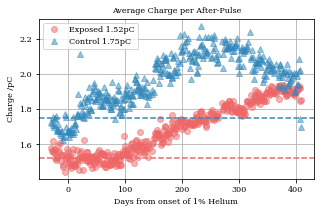

In [96]:

print(y[1][10:70],np.average(y[1][10:70]))
plt.figure(figsize=figsize, facecolor='white')
plt.plot(x[0], y[0], "o", label='Exposed {:.2f}pC'.format(np.average(y[0][10:70])), alpha=0.5)
plt.plot(x[1], y[1], "^", label='Control {:.2f}pC'.format(np.average(y[1][10:70])), alpha=0.5)
plt.axhline(np.average(y[0][10:70]), ls='--', color='C0')
plt.axhline(np.average(y[1][10:70]), ls='--', color='C1')
plt.ylabel("Charge /pC")
plt.xlabel("Days from onset of 1% Helium")
plt.title("Average Charge per After-Pulse")
plt.legend(loc='best')
plt.tight_layout()
plt.savefig("/Users/williamquinn/Desktop/av_ap_charge_vs_time.pdf")

In [98]:
y = [[], []]
x = [[], []]
for i in range(len(ap_pes)):
    for j in range(len(ap_pes[i])):
        if ap_pes[i][j] > 10:
            pass
        elif str(ap_pes[i][j]) == 'nan':
            pass
        else:
            y[i].append(ap_pes[i][j])
            x[i].append(dates[i][j])

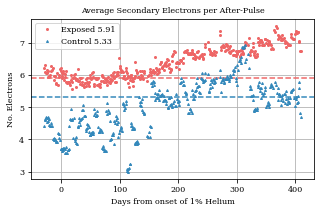

In [104]:
plt.figure(figsize=figsize, facecolor='white')
plt.plot(x[0], y[0], "o", label='Exposed {:.2f}'.format(np.average(y[0][10:70])), alpha=1, markersize=2)
plt.axhline(np.average(y[0][10:70]), color="C0", ls='--')
plt.plot(x[1], y[1], "^", label='Control {:.2f}'.format(np.average(y[1][-70:])), alpha=1, markersize=2)
plt.axhline(np.average(y[1][-70:]), color="C1", ls='--')
plt.ylabel("No. Electrons")
plt.xlabel("Days from onset of 1% Helium")
plt.title("Average Secondary Electrons per After-Pulse")
plt.legend(loc='best')
plt.tight_layout()
plt.savefig("/Users/williamquinn/Desktop/av_ap_pe_vs_time.pdf")

In [109]:
filename = "/Users/williamquinn/Desktop/data/set_5/200306_A1400_B1400_t2134.root"
file = ROOT.TFile(filename, "READ")
file.cd()
tree = file.T

date = filename.split("/")[-1].split("_")[0]
voltage = 1400
week = process_date([int(date)])[0] // 7

temp_charge = []
temp_pe = []

for event in tree:
    om = event.OM_ID
    if om == 1:
        continue
    amps = list(event.apulse_amplitudes)
    shapes = list(event.apulse_shapes)
    ts = list(event.apulse_times)
        
    try:
        gain = gains[om][week + 5]
    except:
        print(week, date)
        
    for i_ap, ap in enumerate(amps):
        shp = shapes[i_ap]
        if shp < 0.95 and ap < 25:
            continue
        charge = -1*np.sum(unit_y)*ap/amp_scale /50
        pe = charge*1e-12 /gain /1.602e-19 
        temp_charge.append(charge)
        temp_pe.append(pe)
    

In [115]:
from math import factorial
def poisson(k, mu, A):
    y = []
    for i in range(len(k)):
        y.append(A*(mu**k[i])*np.exp(-1*mu)/factorial(int(k[i])))
    return y
def town(x, A, B, C):
    return x*C*np.exp(A*x)/(1 - B*(np.exp(A*x) - 1))

In [83]:
freq, bin_edges = np.histogram(temp_pe, range=(0,15), bins=15)
width = bin_edges[2] - bin_edges[1]
bin_centres = bin_edges[:-1] + width/2

In [84]:
from scipy.optimize import curve_fit
popt, pcov = curve_fit(f=poisson, xdata=bin_centres, ydata=freq, p0=[np.average(temp_pe), np.amax(freq)])

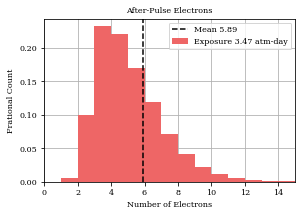

In [86]:
exposure = 3.47
plt.figure(figsize=figsize, facecolor='white')
plt.bar(bin_centres, freq/np.sum(freq), width=width, alpha=1, label='Exposure {} atm-day'.format(exposure))
plt.xlim(0, 15)
plt.xlabel("Number of Electrons")
plt.ylabel("Frational Count")

plt.axvline(np.average(temp_pe), ls='--', color='k', label='Mean {:.2f}'.format(np.average(temp_pe)))
# plt.bar(bin_centres, poisson(bin_centres, *popt), color="C1", alpha=0.2, width =1)
plt.legend(loc='best')
plt.title("After-Pulse Electrons")
plt.savefig("/Users/williamquinn/Desktop/ap_pe.pdf")

/var/folders/z0/ktldz45s5hn1fwbvyy8qxzdh0000gn/T/ipykernel_79845/160314272.py:8: RuntimeWarning: overflow encountered in exp
  return x*C*np.exp(A*x)/(1 - B*(np.exp(A*x) - 1))
/var/folders/z0/ktldz45s5hn1fwbvyy8qxzdh0000gn/T/ipykernel_79845/160314272.py:8: RuntimeWarning: overflow encountered in multiply
  return x*C*np.exp(A*x)/(1 - B*(np.exp(A*x) - 1))
/var/folders/z0/ktldz45s5hn1fwbvyy8qxzdh0000gn/T/ipykernel_79845/160314272.py:8: RuntimeWarning: invalid value encountered in true_divide
  return x*C*np.exp(A*x)/(1 - B*(np.exp(A*x) - 1))


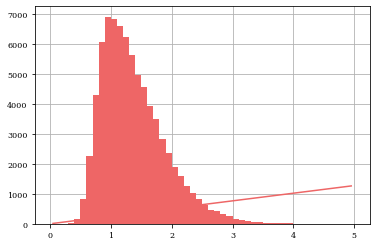

In [117]:

freq, bin_edges = np.histogram(temp_charge, range=(0,5), bins=50)
width = bin_edges[2] - bin_edges[1]
bin_centres = bin_edges[:-1] + width/2
plt.bar(bin_centres, freq, width=width, alpha=1)

popt, pcov = curve_fit(town, bin_centres, freq)

plt.plot(bin_centres, town(bin_centres, *popt))